# Protein Ensemble: CNN + LSTM

In [ ]:
# (Please, be aware that it might be necessary to import this library for the hiperparameter tuning)
pip install bayesian-optimization

In [ ]:
# Set Up & Libraries

import pandas as pd
import numpy as np
import time
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
import random
import seaborn as sns
import json

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

Device: cuda


In [ ]:
# Importing Dataset

df = pd.read_csv("/content/2018-06-06-pdb-intersect-pisces.csv")
print(df.shape)
print(df.columns)

(9078, 11)
Index(['pdb_id', 'chain_code', 'seq', 'sst8', 'sst3', 'len', 'has_nonstd_aa',
       'Exptl.', 'resolution', 'R-factor', 'FreeRvalue'],
      dtype='object')


In [ ]:
# Test Set

test_size = int(.1 * df.shape[0]) # 10% of data for test set
test_ix = random.sample([i for i in range(df.shape[0])] , test_size)
df_test = df.iloc[test_ix]
df = df.drop(test_ix)
print(df.shape)
print(df_test.shape)

(8171, 11)
(907, 11)


# Preprocessing

(Please, be aware that this section is the same across notebooks with the same tokenization technique)

## Padding & Cropping

In [ ]:
def pad_sequence(seq_df, maxlen):
    """This function pads with dots a sequence until it has the desired length"""
    out = ['<'+i+'>'+'.'*(maxlen-len(i)) for i in seq_df]
    return out

def crop_sequence(seq_long , max_len):
    """This function breaks a sequence into subsequences of the desired length"""
    # Cracking Sequence
    out_1 = ['<'+seq_long[j][i-max_len:i]+'.' for j in seq_long.index for i in range(max_len , len(seq_long[j]) , max_len)]
    # Extracting and padding last part of each sequence
    out_2 = [seq_long[j][max_len * (int(len(seq_long[j])/max_len)) : len(seq_long[j])] for j in seq_long.index]
    out_2 = pad_sequence(out_2 , max_len)
    # Unifying both
    out_1.extend(out_2)
    return out_1

def crop_pad_sequences(df , max_len):
  # Dividing Dataset
  df_short = df[df['seq'].str.len() < max_len] # Needs padding
  df_exact = df[df['seq'].str.len() == max_len] # Nothing
  df_long = df[df['seq'].str.len() > max_len] # Needs Cropping

  # Preparing features
  seq_short = pad_sequence(df_short['seq'], max_len)
  seq_exact = ['<'+i+'>' for i in df_exact['seq']]
  seq_long = crop_sequence(df_long['seq'], max_len)
  seq_features = [i for l in [seq_short, seq_exact, seq_long] for i in l] # Joining all three
  print(f'Number of Sequences: {len(seq_features)}')

  # Preparing q3
  q3_short = pad_sequence(df_short['sst3'], max_len)
  q3_exact = ['<'+i+'>' for i in df_exact['sst3']]
  q3_long = crop_sequence(df_long['sst3'], max_len)
  q3 = [i for l in [q3_short, q3_exact, q3_long] for i in l] # Joining all three
  print(f'Number of Sequences: {len(q3)}')

  # Preparing q8
  q8_short = pad_sequence(df_short['sst8'], max_len)
  q8_exact = ['<'+i+'>' for i in df_exact['sst8']]
  q8_long = crop_sequence(df_long['sst8'], max_len)
  q8 = [i for l in [q8_short, q8_exact, q8_long] for i in l] # Joining all three
  print(f'Number of Sequences: {len(q8)}')

  # Checking
  for i in [q8 , q3 , seq_features]:
      lens = [len(j) for j in i]
      print(f'Sequences without desired length: {[j for j in lens if j != max_len+2]}')

  return seq_features , q3 , q8

In [ ]:
# Sequence Standarization
max_len = int(np.mean(df['len'])) #Hyperparam

seq_features , q3 , q8 = crop_pad_sequences(df , max_len)

Number of Sequences: 12286
Number of Sequences: 12286
Number of Sequences: 12286
Sequences without desired length: []
Sequences without desired length: []
Sequences without desired length: []


## Encoders, Decoders & Vocabs

In [ ]:
def enc_dec_vocab(sequence):
  seq_vocab = np.unique([j for i in sequence for j in i]) # Vocab Dictionary
  seq_stoi = {str(j):i for i,j in enumerate(seq_vocab)} # String-to-Int
  seq_itos = {i:str(j) for i,j in enumerate(seq_vocab)} # Int-to-String
  seq_encoder = lambda s: [seq_stoi[c] for c in s] # encoder function
  seq_decoder = lambda s: [seq_itos[c] for c in s] # decoder function
  print(f'Sequence vocabulary: {seq_vocab} | Vocab Length: {len(seq_vocab)}\n\n')

  return seq_encoder , seq_decoder , seq_vocab, seq_stoi, seq_itos

In [ ]:
# Features
seq_encoder , seq_decoder , seq_vocab, seq_stoi, seq_itos = enc_dec_vocab(seq_features)
# Q3
q3_encoder , q3_decoder , q3_vocab, q3_stoi, q3_itos = enc_dec_vocab(q3)
# Q8
q8_encoder , q8_decoder , q8_vocab, q8_stoi, q8_itos = enc_dec_vocab(q8)

Sequence vocabulary: ['*' '.' '<' '>' 'A' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'P' 'Q'
 'R' 'S' 'T' 'V' 'W' 'Y'] | Vocab Length: 24


Sequence vocabulary: ['.' '<' '>' 'C' 'E' 'H'] | Vocab Length: 6


Sequence vocabulary: ['.' '<' '>' 'B' 'C' 'E' 'G' 'H' 'I' 'S' 'T'] | Vocab Length: 11




## Data Exploration


Descriptive Statistics for Sequence Lengths:
count    8171.000000
mean      243.779219
std       156.717423
min        20.000000
25%       131.500000
50%       209.000000
75%       324.000000
max      1632.000000
Name: len, dtype: float64


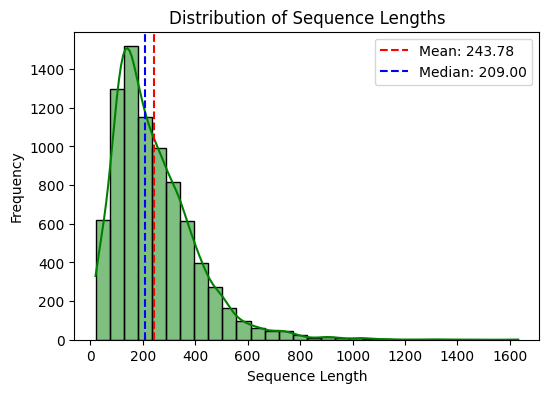

In [ ]:
# Descriptive statistics for sequence lengths
sequence_lengths = df['len']
print("\nDescriptive Statistics for Sequence Lengths:")
print(sequence_lengths.describe())

# Visualizing the distribution with descriptive statistics
plt.figure(figsize=(6, 4))
sns.histplot(sequence_lengths, bins=30, kde=True, color='green')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(sequence_lengths.mean(), color='r', linestyle='--', label=f'Mean: {sequence_lengths.mean():.2f}')
plt.axvline(sequence_lengths.median(), color='b', linestyle='--', label=f'Median: {sequence_lengths.median():.2f}')
plt.legend()
plt.show()

# Conclusion: Highly skewed distribution of lengths

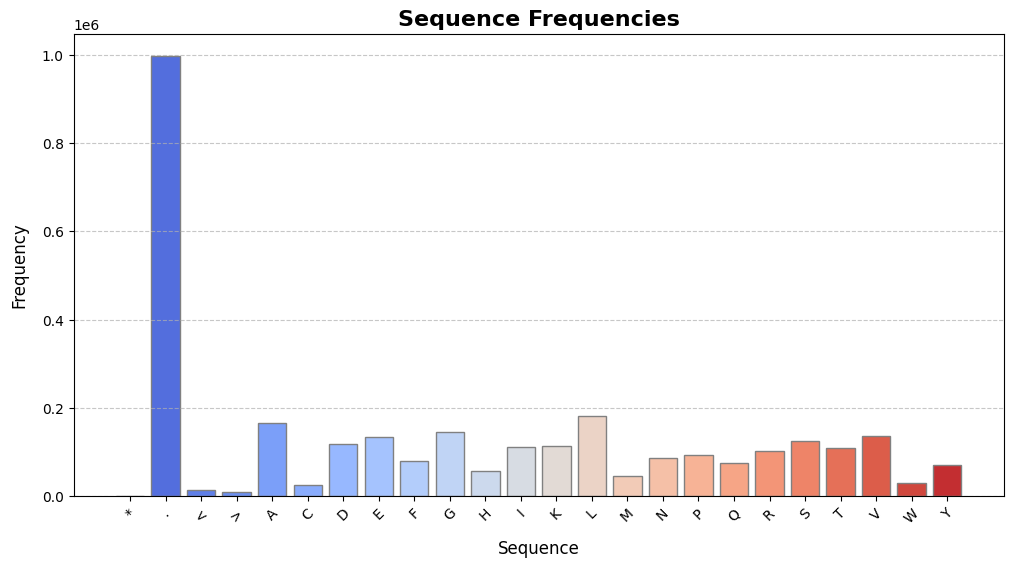

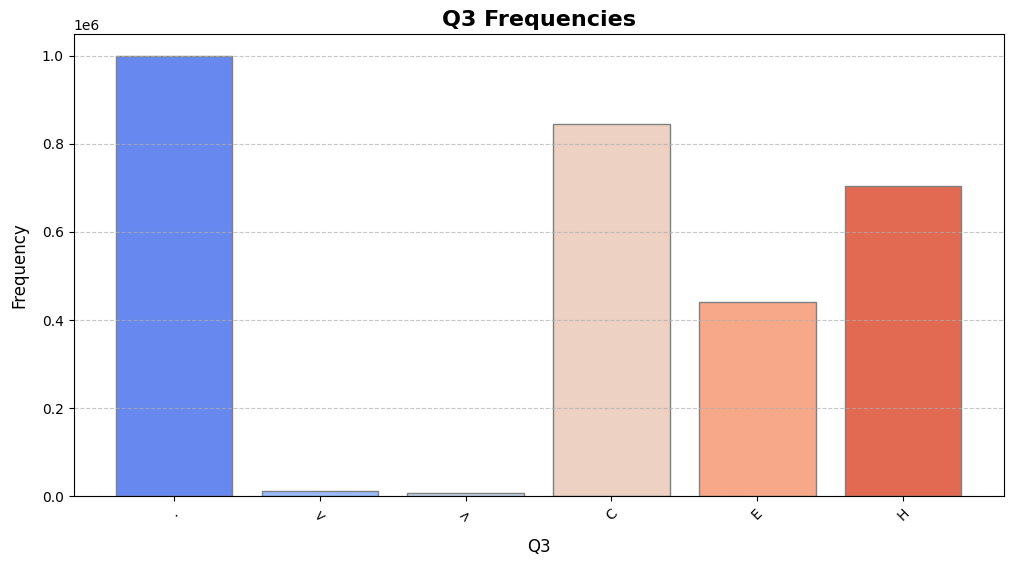

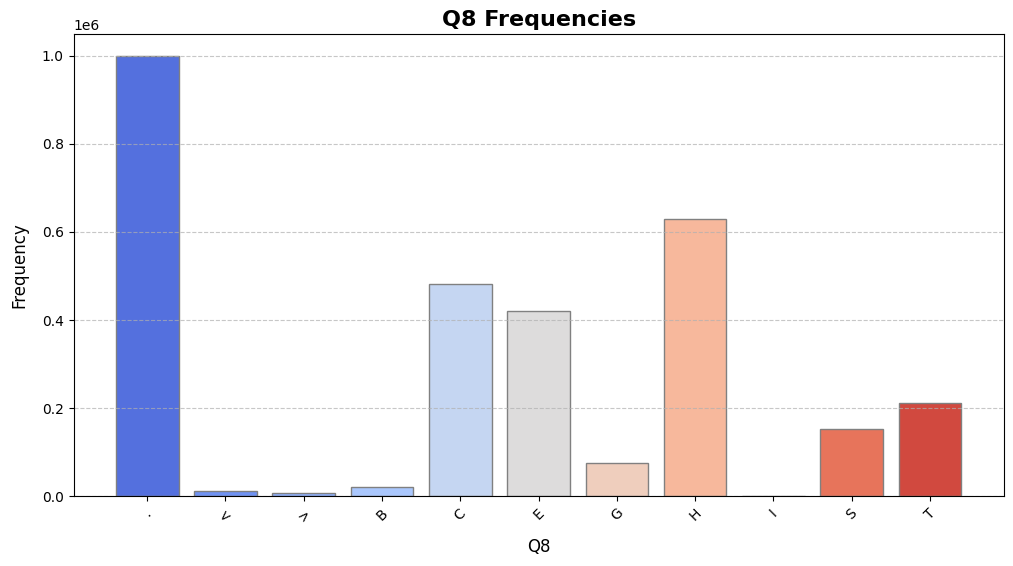

In [ ]:
# Statistics for Class Frequency in Each Data Type (Sequence, Q3 & Q8)

colors_seq = sns.color_palette("coolwarm", len(seq_vocab))
seqs = np.array([seq_encoder(i) for i in seq_features])
seqs_freqs = np.unique(seqs , return_counts  = True)
seq_freqs = {i[0]:i[1] for i in zip(seqs_freqs[0] , seqs_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([seq_itos[i] for i in list(seq_freqs.keys())] , seq_freqs.values() , color=colors_seq, edgecolor='grey')
plt.title('Sequence Frequencies', fontsize=16, weight='bold')
plt.xlabel('Sequence', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45 , ticks = list(seq_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


colors_q3 = sns.color_palette("coolwarm", len(q3_vocab))
q3s = np.array([q3_encoder(i) for i in q3])
q3s_freqs = np.unique(q3s , return_counts  = True)
q3s_freqs = {i[0]:i[1] for i in zip(q3s_freqs[0] , q3s_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([q3_itos[i] for i in list(q3s_freqs.keys())] , q3s_freqs.values() , color=colors_q3, edgecolor='grey')
plt.title('Q3 Frequencies', fontsize=16, weight='bold')
plt.xlabel('Q3', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45 , ticks = list(q3s_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


colors_q8 = sns.color_palette("coolwarm", len(q8_vocab))
q8s = np.array([q8_encoder(i) for i in q8])
q8s_freqs = np.unique(q8s , return_counts  = True)
q8s_freqs = {i[0]:i[1] for i in zip(q8s_freqs[0] , q8s_freqs[1])}
plt.figure(figsize=(12, 6))
plt.bar([q8_itos[i] for i in list(q8s_freqs.keys())] , q8s_freqs.values() , color=colors_q8, edgecolor='grey')
plt.title('Q8 Frequencies', fontsize=16, weight='bold')
plt.xlabel('Q8', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontsize=12, labelpad=10)
plt.xticks(rotation=45 , ticks = list(q8s_freqs.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Conclusion: Sequences and Q3 do not present much imbalance between classes. Q8 is highly unbalanced, with I
# being almost not-present

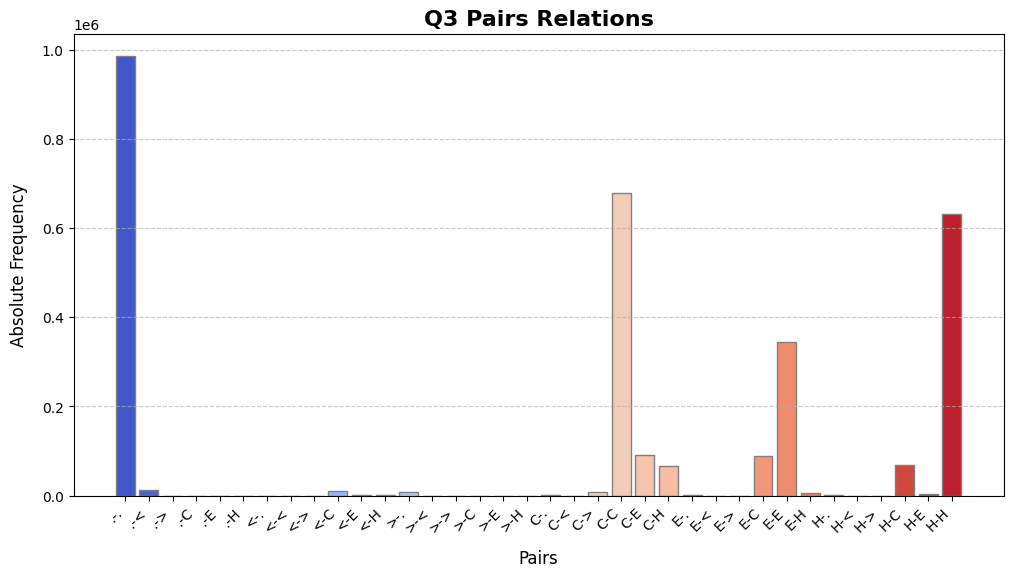

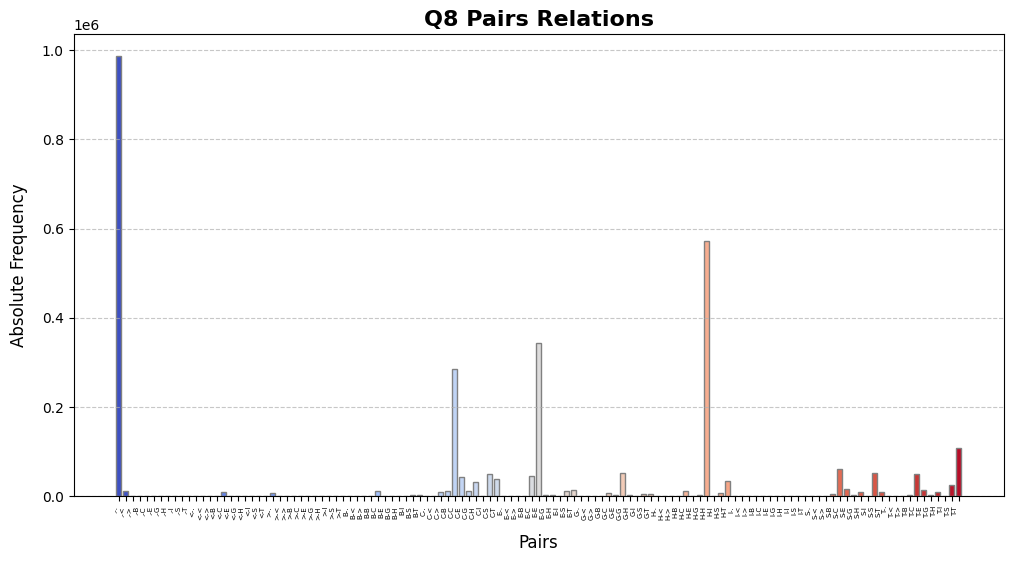

In [ ]:
# Statistics on Bigram Frequencies

q3_pairs = {f"{i1}-{i2}":0 for i1 in list(q3_vocab) for i2 in list(q3_vocab)}
colors_q3_pairs = sns.color_palette("coolwarm", len(q3_pairs))
q3_all = "".join(q3)
for i in zip(q3_all , q3_all[1:]):
  q3_pairs[f"{i[0]}-{i[1]}"] +=1
plt.figure(figsize=(12, 6))
bars = plt.bar(q3_pairs.keys(), q3_pairs.values(), color=colors_q3_pairs, edgecolor='grey')
plt.title("Q3 Pairs Relations", fontsize=16, weight='bold')
plt.xlabel("Pairs", fontsize=12, labelpad=10)
plt.ylabel("Absolute Frequency", fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


q8_pairs = {f"{i1}-{i2}":0 for i1 in list(q8_vocab) for i2 in list(q8_vocab)}
colors_q8_pairs = sns.color_palette("coolwarm", len(q8_pairs))
q8_all = "".join(q8)
for i in zip(q8_all , q8_all[1:]):
  q8_pairs[f"{i[0]}-{i[1]}"] +=1
plt.figure(figsize=(12, 6))
bars = plt.bar(q8_pairs.keys(), q8_pairs.values(), color=colors_q8_pairs, edgecolor='grey')
plt.title("Q8 Pairs Relations", fontsize=16, weight='bold')
plt.xlabel("Pairs", fontsize=12, labelpad=10)
plt.ylabel("Absolute Frequency", fontsize=12, labelpad=10)
plt.xticks(rotation=90, ha='right', fontsize=5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Conclusion: Equipairs dominate the distribution. Highly unbalanced.

## Datasets & Dataloaders

In [ ]:
# Torchification
X = torch.tensor(seqs , device=device)
Y_q3 = torch.tensor(q3s , device=device)
Y_q8 = torch.tensor(q8s , device=device)
data_dict = {'X':X , 'Y_q3':Y_q3, 'Y_q8':Y_q8}
torch.save(data_dict , 'data_dictionary')

print(f'X shape: {X.shape} | Y_q3 shape: {Y_q3.shape} | Y_q8 shape: {Y_q8.shape}')

X shape: torch.Size([12286, 245]) | Y_q3 shape: torch.Size([12286, 245]) | Y_q8 shape: torch.Size([12286, 245])


In [ ]:
# Custom Dataset & Dataloader

class CustomDataset(Dataset):
    """This is the class for creating a custom DataSet given two tensors"""
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

def intialise_loaders(X_train , y_train , X_val , y_val , batch_size):
    """This function creates two dataloader given two numpy arrays"""
    train_dataset = CustomDataset(X = X_train , y = y_train)
    val_dataset = CustomDataset(X = X_val , y = y_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader

# Model

## Ensemble Model

In [ ]:
# Hyperparameters for Transformer
context_size = max_len+2
eval_interval = 1 # Estimate loss each x
n_emb = int(64)
vocab_size = len(seq_vocab)
q3_vocab_size = len(q3_vocab)
q8_vocab_size = len(q8_vocab)
reduc = 0.005
hs = 128
ff = 64
md = 0.05
factor = 0.1
max_iters = 15
dropout = 0.3

In [ ]:
class ProteinLSTM(nn.Module):
    def __init__(self , vs , n_emb , n_layers , hidden , dropout , ker , vocab_size):
        super().__init__()
        self.enc_token_embeddings_table = nn.Embedding(vocab_size , n_emb , device=device)
        self.lstm = nn.LSTM(input_size=n_emb , num_layers = n_layers , hidden_size = hidden ,
                            batch_first = True, dropout=dropout)
        self.ln_1 = nn.LayerNorm(hidden)
        self.conv = nn.Conv1d(in_channels = hidden, out_channels = int(hidden/2), kernel_size = ker, padding = 'same')
        self.ln_2 = nn.LayerNorm(int(hidden/2))
        self.lk_rl = nn.LeakyReLU()
        self.lm_head = nn.Linear(int(hidden/2) , vs , device=device)

    def forward(self , x):
        x = self.enc_token_embeddings_table(x)
        x , _ = self.lstm(x)
        x = self.ln_1(x)
        x = self.conv(x.permute(0,2,1)).permute(0,2,1)
        x = self.lk_rl(self.ln_2(x))
        logits = self.lm_head(x)
        return logits

    def inference(self , x , enc):
      # This method allows for the input of a sequence of aminoacids, cropps it or pads it, encodes it and predicts
         # the structure of it

        # Number of structure tokens to predict (Structure Len == Sequence Length)
        iters = len(x)

        # Adjusting length
        if len(x) < context_size-2:
          # Padding
            x = ['<' + x + '>' + '.'*(context_size-len(x)-2)] # Adding SOS & EOS & Padding
            batches = 1
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device) # Prediction (initially empty)
            idx[0,0] = enc('<')[0] # Start of the sequence
            idx[-1,-1] = enc('<')[0] # End of Sequence

        elif len(x) > context_size-2:
          # Cropping
            x_1 = [x[i-context_size+1:i] for i in range(context_size-1 , len(x) , context_size)]
            x_2 = x[context_size * (int(len(x)/context_size)) : len(x)]
            x_2 = [x_2 + '>' + '.'*(context_size-len(x_2)-1)][0]
            x = [x_1[i] + '.' if i != 0 else '<' + x_1[i] for i in range(len(x_1))]
            x.append(x_2)
            batches = len(x)
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device)
            idx[:,0] = enc('<')[0]

        else:
          # Exact Legnth
            x = ['<' + x + '>']
            batches = 1
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device)
            idx[0,0] = enc('<')[0] # Start of the sequence
            idx[-1,-1] = enc('<')[0] # End of Sequence

        # Encoding & Torchification
        x = torch.tensor([enc(i) for i in x] , device=device)

        # Sampling from the distribution
        probs = F.softmax(self(x) , dim=-1)
        B, T, C = probs.shape
        probs_flat = probs.view(-1, C)
        idx = torch.multinomial(probs_flat , num_samples=1, replacement=True)
        return idx

In [ ]:
class ProteinCNN(nn.Module):
    def __init__(self, vs, n_emb, num_filters, kernel_size, num_conv_layers, dropout):
        super(ProteinCNN, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_emb, device=device)
        self.dropout = nn.Dropout(dropout)

        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            in_channels = n_emb if i == 0 else num_filters
            self.conv_layers.append(
                nn.Conv1d(in_channels, num_filters, kernel_size, padding=kernel_size // 2)
            )
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.Dropout(dropout))

        self.fc = nn.Linear(num_filters, vs, device=device)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.token_embedding(x)  # (batch_size, seq_len, n_emb)
        x = x.transpose(1, 2)        # (batch_size, n_emb, seq_len)
        x = self.dropout(x)
        for layer in self.conv_layers:
            x = layer(x)             # (batch_size, num_filters, seq_len)
        x = x.transpose(1, 2)        # (batch_size, seq_len, num_filters)
        logits = self.fc(x)          # (batch_size, seq_len, vs)
        return logits


In [ ]:
class CrossAtt(nn.Module):
    def __init__(self , vs , head_size, dropout):
      super().__init__()
      self.Q = nn.Linear(vs , head_size , device=device)
      self.K = nn.Linear(vs , head_size , device=device)
      self.V = nn.Linear(vs , head_size , device=device)
      self.dropout = nn.Dropout(dropout)

    def forward(self , x1 , x2):
      q = self.Q(x1) # (B,T,hs)
      k = self.K(x2) # (B,T,hs)
      v = self.V(x2) # (B,T,hs)
      weights = (q @ k.transpose(1,2)) / (k.shape[-1] ** 0.5) # (B,T,T)
      weights = F.softmax(weights , dim=-1)
      weights = self.dropout(weights[0,:,:])
      out = weights @ v # (B,T,T) @ (B,T,hs) = (B,T,hs)
      return out



class EnsembleProtein(nn.Module):
    def __init__(self , lstm , cnn , hs , vs , ff , dropout):
        super().__init__()
        self.lstm = lstm
        self.cnn = cnn
        self.CrossAtt = CrossAtt(vs , hs , dropout)
        self.ff1 = nn.Linear(hs , vs*ff)
        self.ff2 = nn.Linear(vs*ff , vs)

        # Freezing the already trained models
        for param in self.lstm.parameters():
            param.requires_grad = False
        for param in self.cnn.parameters():
            param.requires_grad = False


    def forward(self , x):
        lstm_logits = self.lstm(x) # (B,T,C)
        cnn_logits = self.cnn(x) # (B,T,C)
        x = self.CrossAtt(lstm_logits , cnn_logits)
        x = F.sigmoid(self.ff1(x))
        logits = self.ff2(x) + lstm_logits + cnn_logits
        return logits


    def inference(self , x , enc):
      # This method allows for the input of a sequence of aminoacids, cropps it or pads it, encodes it and predicts
         # the structure of it

        # Number of structure tokens to predict (Structure Len == Sequence Length)
        iters = len(x)

        # Adjusting length
        if len(x) < context_size-2:
          # Padding
            x = ['<' + x + '>' + '.'*(context_size-len(x)-2)] # Adding SOS & EOS & Padding
            batches = 1
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device) # Prediction (initially empty)
            idx[0,0] = enc('<')[0] # Start of the sequence
            idx[-1,-1] = enc('<')[0] # End of Sequence

        elif len(x) > context_size-2:
          # Cropping
            x_1 = [x[i-context_size+1:i] for i in range(context_size-1 , len(x) , context_size)]
            x_2 = x[context_size * (int(len(x)/context_size)) : len(x)]
            x_2 = [x_2 + '>' + '.'*(context_size-len(x_2)-1)][0]
            x = [x_1[i] + '.' if i != 0 else '<' + x_1[i] for i in range(len(x_1))]
            x.append(x_2)
            batches = len(x)
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device)
            idx[:,0] = enc('<')[0]

        else:
          # Exact Legnth
            x = ['<' + x + '>']
            batches = 1
            idx = torch.full((batches, context_size), enc('.')[0], dtype=torch.int , device=device)
            idx[0,0] = enc('<')[0] # Start of the sequence
            idx[-1,-1] = enc('<')[0] # End of Sequence

        # Encoding & Torchification
        x = torch.tensor([enc(i) for i in x] , device=device)

        # Sampling from the distribution
        probs = F.softmax(self(x) , dim=-1)
        B, T, C = probs.shape
        probs_flat = probs.view(-1, C)
        idx = torch.multinomial(probs_flat , num_samples=1, replacement=True)
        return idx

In [ ]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# Training loop class
class Training:
    def __init__(self , data , model , hyperparams , loss_func , verbose=False , valid=True):
        self.train_loader , self.val_loader = intialise_loaders(data['x_train'] , data['y_train'] ,
                                                                data['x_val'] , data['y_val'] , hyperparams['batch_size'])
        self.model = model
        self.optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()) , lr=hyperparams['lr'])
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'])
        self.hist_loss = {'train':[] , 'val':[]}
        self.hist_acc = {'train':[] , 'val':[]}
        self.hist_pres = {'train':[] , 'val':[]}
        self.hist_f1 = {'train':[] , 'val':[]}
        self.times = []
        self.hyper = hyperparams
        self.loss_func = loss_func
        self.early = EarlyStopper(patience = self.hyper['patience'] , min_delta = self.hyper['min_delta'])
        self.verbose = verbose
        self.valid = valid

    def __call__(self, *args, **kwargs):
      for i in range(self.hyper['epochs']):
            t = time.time()
            lossi = 0
            acci = 0
            all_preds = []
            all_targets = []
            for batch , (X_i,y_i) in enumerate(self.train_loader):
                logits = self.model(X_i)
                probs = F.softmax(logits , dim=-1)
                loss = self.loss_func(logits.view(-1 , logits.shape[-1]) , y_i.view(-1))
                acc = (torch.argmax(probs , dim=-1) == y_i).float().mean()
                self.optimizer.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()
                lossi += loss.item()
                acci += acc.item()
                all_preds.extend(torch.argmax(probs , dim=-1).view(-1).cpu().numpy())
                all_targets.extend(y_i.contiguous().view(-1).cpu().numpy())

            self.hist_loss['train'].append(lossi/len(self.train_loader))
            self.hist_acc['train'].append(acci/len(self.train_loader))
            self.hist_pres['train'].append(precision_score(all_targets , all_preds , average='weighted' , zero_division=1))
            self.hist_f1['train'].append(f1_score(all_targets , all_preds , average='weighted' , zero_division=1))
            if self.verbose:
                print(f'Epoch: {i+1}/{self.hyper["epochs"]} | Training Loss: {self.hist_loss["train"][-1]:.5f} | Training Accuracy: {self.hist_acc["train"][-1]:.5f} |'
                      f'Training Precision: {self.hist_pres["train"][-1]:.5f} | Training F1-Score: {self.hist_f1["train"][-1]:.5f}')

            if i % self.hyper['eval_int'] == 0 and self.valid == True:
                lossi = 0
                acci = 0
                all_preds = []
                all_targets = []
                for batch , (X_i,y_i) in enumerate(self.val_loader):
                    logits = self.model(X_i)
                    probs = F.softmax(logits , dim=-1)
                    loss = self.loss_func(logits.view(-1 , logits.shape[-1]) , y_i.view(-1))
                    lossi += loss.item()
                    acc = (torch.argmax(F.softmax(probs , dim=-1) , dim=-1) == y_i).float().mean()
                    acci += acc.item()
                    all_preds.extend(torch.argmax(probs , dim=-1).view(-1).cpu().numpy())
                    all_targets.extend(y_i.contiguous().view(-1).cpu().numpy())

                self.hist_acc['val'].append(acci/len(self.val_loader))
                self.hist_loss['val'].append(lossi/len(self.val_loader))
                self.hist_pres['val'].append(precision_score(all_targets ,all_preds , average='weighted' , zero_division=1))
                self.hist_f1['val'].append(f1_score(all_targets , all_preds , average='weighted' , zero_division=1))
                stop = self.early.early_stop(1/self.hist_f1['val'][-1])
                if stop:
                  if self.verbose:
                    print(f'Patience surpassed --> Stopping')
                  break
                self.scheduler.step(self.hist_loss['val'][-1])
                if self.verbose:
                    print(f'Epoch: {i+1}/{self.hyper["epochs"]} | Validation Loss: {self.hist_loss["val"][-1]:.5f} | '
                          f'Validation Accuracy: {self.hist_acc["val"][-1]:.5f} | Learning Rate: {self.optimizer.param_groups[0]["lr"]} |'
                          f'Validation Precision: {self.hist_pres["val"][-1]:.5f} | Validation F1-Score: {self.hist_f1["val"][-1]:.5f}')
            self.times.append(time.time()-t)

In [ ]:
#Diversity Loss
class Diversity_Loss():
  def __init__(self , reduc, T, C , stoi):
    self.loss_fn = nn.CrossEntropyLoss(ignore_index=stoi['.'])
    self.T = T
    self.C = C
    self.reduc = reduc

  def __call__(self, logits, y):
    loss = self.loss_fn(logits , y)
    probs = F.softmax(logits.view(-1,self.T,self.C) , dim=-1)
    diversity = torch.sum(probs , dim=-2 , keepdim=False)
    diversity , _ = torch.max(diversity , dim=-1 , keepdim=False)
    loss += self.reduc * torch.mean(diversity)
    return loss

In [ ]:
# Load the best parameters for Q3 from the JSON file
params_json_path_q3 = '/content/optimized_q3_params.json'
with open(params_json_path_q3, 'r') as json_file:
    best_params_q3 = json.load(json_file)
# Load the best parameters for Q8 from the JSON file
params_json_path_q8 = '/content/optimized_q8_params.json'
with open(params_json_path_q8, 'r') as json_file:
    best_params_q8 = json.load(json_file)

In [ ]:
# Loading Pre-Trained Models
# Q3
# LSTM
lstm_q3 =  ProteinLSTM(q3_vocab_size , n_emb=128 , n_layers=2 , hidden=32 , dropout=0.4 , ker=1 , vocab_size=vocab_size)
lstm_q3.to(device)
state_dict = torch.load('/content/Q3_protein_lstm_notoken.pth')
lstm_q3.load_state_dict(state_dict)

# CNN
cnn_q3 =  ProteinCNN(vs=q3_vocab_size, n_emb=int(best_params_q3['n_emb']), num_filters=int(best_params_q3['num_filters']), kernel_size=int(best_params_q3['kernel_size']),
                      num_conv_layers=int(best_params_q3['num_conv_layers']), dropout=int(best_params_q3['dropout']))
cnn_q3.to(device)
state_dict = torch.load('/content/Q3_protein_cnn_no_token_optimized.pth')
cnn_q3.load_state_dict(state_dict)



# Q8
# LSTM
lstm_q8 = ProteinLSTM(q8_vocab_size , n_emb=90 , n_layers=2 , hidden=32 , dropout=0.4 , ker=1 , vocab_size=vocab_size)
lstm_q8.to(device)
state_dict = torch.load('/content/Q8_protein_lstm_notoken.pth')
lstm_q8.load_state_dict(state_dict)

# CNN
cnn_q8 =  ProteinCNN(vs=q8_vocab_size, n_emb=int(best_params_q8['n_emb']), num_filters=int(best_params_q8['num_filters']), kernel_size=int(best_params_q8['kernel_size']),
                      num_conv_layers=int(best_params_q8['num_conv_layers']), dropout=int(best_params_q8['dropout']))

state_dict = torch.load('/content/Q8_protein_cnn_no_token_optimized.pth')
cnn_q8.load_state_dict(state_dict)

<ipython-input-92-6a8617dd35e6>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/Q3_protein_lstm_notoken.pth')
<ipython-input-92-6a8617dd35

<All keys matched successfully>

## Evaluation Functions

In [ ]:
def plot_learning_curves(tr):
    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_loss['train'], label='Training Loss')
    plt.plot(tr.hist_loss['val'], label='Validation Loss')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(tr.hist_acc['train'], label='Training Accuracy')
    plt.plot(tr.hist_acc['val'], label='Validation Accuracy')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, tr, itos, stoi, title='Confusion Matrix'):
    model.eval()

    # Initialize lists to store all predictions and labels
    all_preds = []
    all_labels = []

    # Get the padding index to exclude it from the confusion matrix
    pad_idx = stoi['.']

    with torch.no_grad():
        for batch, (X_i, y_i) in enumerate(tr.val_loader):
            logits = model(X_i)
            preds = torch.argmax(logits, dim=-1)

            # Flatten predictions and labels using reshape instead of view
            preds_flat = preds.reshape(-1)
            y_i_flat = y_i.reshape(-1)

            # Create a mask to exclude padding tokens in both labels and predictions
            mask = (y_i_flat != pad_idx) & (preds_flat != pad_idx)

            # Apply the mask and move tensors to CPU
            preds_flat = preds_flat[mask].cpu()
            y_i_flat = y_i_flat[mask].cpu()

            # Append to the lists
            all_preds.append(preds_flat)
            all_labels.append(y_i_flat)

    # Concatenate all predictions and labels
    y_pred = torch.cat(all_preds)
    y_true = torch.cat(all_labels)

    # Convert to numpy arrays if they aren't already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Dynamically retrieve the padding index, default to -1 if `.` is not found
    padding_index = stoi.get('.', -1)
    ignore_index = -100

    # Exclude padding and ignore positions (where y_true == ignore_index or padding index)
    mask = (y_true != ignore_index) & (y_true != padding_index)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    # Verify that y_true_filtered and y_pred_filtered contain valid class labels
    valid_labels = sorted(set(y_true_filtered) | set(y_pred_filtered))
    print(f"Valid labels after filtering: {valid_labels}")

    # Generate confusion matrix with the filtered data
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=valid_labels)
    plt.gcf().set_size_inches(12, 10)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[itos[label] for label in valid_labels],
                yticklabels=[itos[label] for label in valid_labels])
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Save the confusion matrix plot before showing it
    #confusion_matrix_path = os.path.join(full_folder_path, 'confusion_matrix.png')
    #plt.savefig(confusion_matrix_path)
    #print(f"Confusion matrix plot saved at: {confusion_matrix_path}")

    # Display the plot
    plt.show()

## Initial Training

#### Q3

In [ ]:
# Splitting Data
# Validation Set
vix = torch.randperm(X.shape[0])[:int(X.shape[0]*.15)]
x_val = X[vix,:]
y_val = Y_q3[vix,:]
# Training Set
ix = torch.tensor(list(set(range(X.shape[0])) - set([i.item() for i in vix])))
x_tr = X[ix]
y_tr = Y_q3[ix]

# Preparing Inputs
loss_func = Diversity_Loss(reduc=reduc , T=context_size , C=len(q3_stoi) , stoi=q3_stoi)
data = {'x_train':x_tr , 'y_train':y_tr , 'x_val':x_val , 'y_val':y_val}
hy = {'batch_size':int(best_params_q3['batch_size']) , 'epochs':max_iters , 'lr':best_params_q3['lr'] ,
      'eval_int':eval_interval , 'patience':int(best_params_q3['patience']) , 'factor':best_params_q3['factor'] , 'min_delta':best_params_q3['min_delta']}
ens = EnsembleProtein(vs = q3_vocab_size , lstm=lstm_q3 , cnn=cnn_q3 , hs=hs , ff=ff , dropout=dropout)
ens.to(device)
print(f"Model's trainable parameters: {sum([i.numel() for i in ens.parameters()])}")


# Training Loop
tr = Training(data=data , model=ens , hyperparams=hy , loss_func=loss_func , verbose=True)
tr()

Model's trainable parameters: 305577
Epoch: 1/15 | Training Loss: 1.77362 | Training Accuracy: 0.42075 |Training Precision: 0.64197 | Training F1-Score: 0.35148
Epoch: 1/15 | Validation Loss: 1.71201 | Validation Accuracy: 0.43033 | Learning Rate: 0.019902764492484442 |Validation Precision: 0.67595 | Validation F1-Score: 0.35925
Epoch: 2/15 | Training Loss: 1.70108 | Training Accuracy: 0.42649 |Training Precision: 0.64804 | Training F1-Score: 0.35707
Epoch: 2/15 | Validation Loss: 1.70915 | Validation Accuracy: 0.40902 | Learning Rate: 0.019902764492484442 |Validation Precision: 0.63407 | Validation F1-Score: 0.33751
Epoch: 3/15 | Training Loss: 1.69652 | Training Accuracy: 0.42739 |Training Precision: 0.64871 | Training F1-Score: 0.35772
Epoch: 3/15 | Validation Loss: 1.68468 | Validation Accuracy: 0.42697 | Learning Rate: 0.019902764492484442 |Validation Precision: 0.65950 | Validation F1-Score: 0.35495
Epoch: 4/15 | Training Loss: 1.71434 | Training Accuracy: 0.42387 |Training Preci

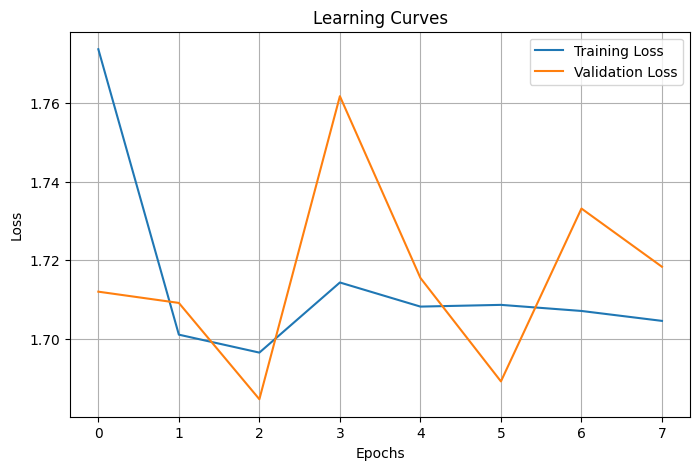

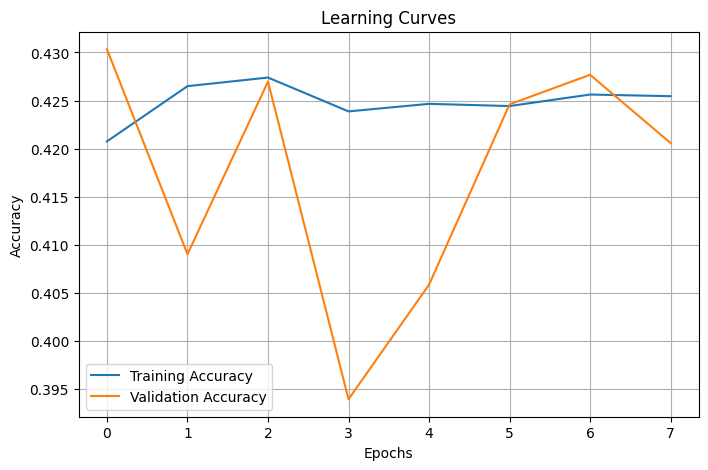

Valid labels after filtering: [1, 2, 3, 4, 5]


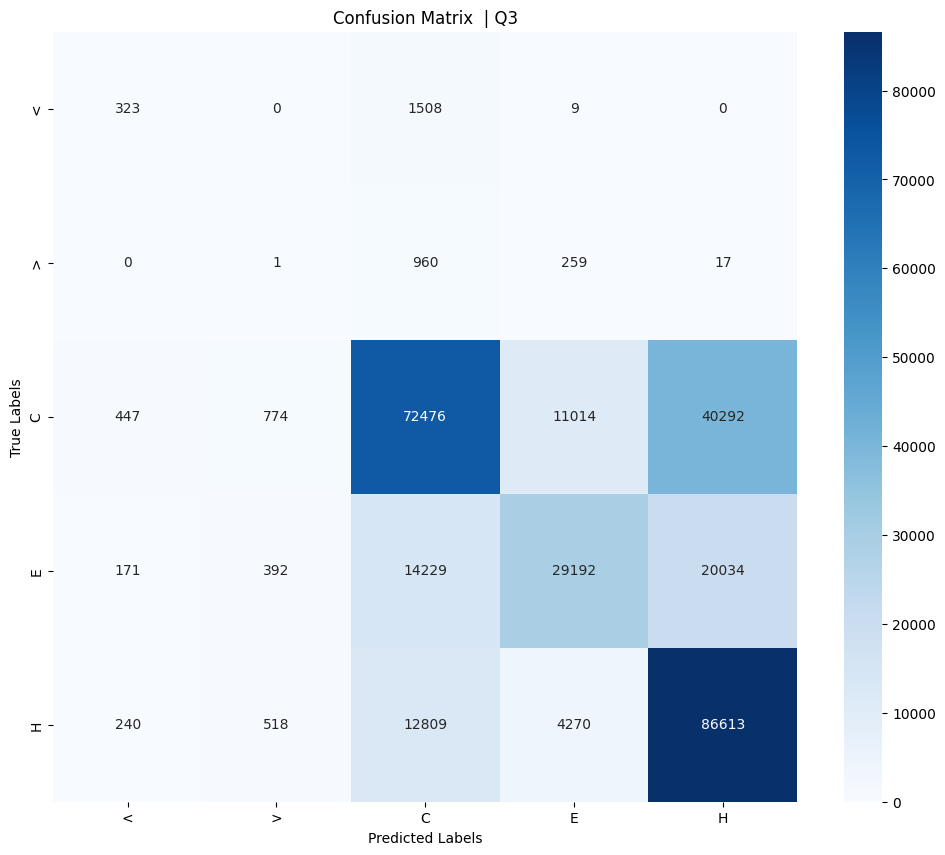

In [ ]:
# Results
plot_learning_curves(tr)
plot_confusion_matrix(ens, tr, q3_itos, q3_stoi, title='Confusion Matrix  | Q3')

# Both the loss and the accuracies seem to be non-improving. However, since in the
# previous models the initial training was not very representative of the final results,
# the experiment of ensemble models should be continued.

#### Q8

In [ ]:
# Splitting Data
# Validation Set
vix = torch.randperm(X.shape[0])[:int(X.shape[0]*.15)]
x_val = X[vix,:]
y_val = Y_q8[vix,:]
# Training Set
ix = torch.tensor(list(set(range(X.shape[0])) - set([i.item() for i in vix])))
x_tr = X[ix]
y_tr = Y_q8[ix]

# Preparing Inputs
loss_func = Diversity_Loss(reduc=reduc , T=context_size , C=len(q8_stoi) , stoi=q3_stoi)
data = {'x_train':x_tr , 'y_train':y_tr , 'x_val':x_val , 'y_val':y_val}
hy = {'batch_size':int(best_params_q8['batch_size']) , 'epochs':max_iters , 'lr':best_params_q8['lr'] ,
      'eval_int':eval_interval , 'patience':int(best_params_q8['patience']) , 'factor':best_params_q8['factor'] , 'min_delta':best_params_q8['min_delta']}
ens = EnsembleProtein(vs = q8_vocab_size , lstm=lstm_q8 , cnn=cnn_q8 , hs=hs , ff=ff , dropout=dropout)
ens.to(device)
print(f"Model's trainable parameters: {sum([i.numel() for i in ens.parameters()])}")


# Training Loop
tr = Training(data=data , model=ens , hyperparams=hy , loss_func=loss_func , verbose=True)
tr()

Model's trainable parameters: 153194
Epoch: 1/15 | Training Loss: 2.19877 | Training Accuracy: 0.34224 |Training Precision: 0.59978 | Training F1-Score: 0.28881
Epoch: 1/15 | Validation Loss: 2.06411 | Validation Accuracy: 0.34937 | Learning Rate: 0.00797051288469486 |Validation Precision: 0.61393 | Validation F1-Score: 0.29431
Epoch: 2/15 | Training Loss: 2.05913 | Training Accuracy: 0.35266 |Training Precision: 0.61580 | Training F1-Score: 0.29354
Epoch: 2/15 | Validation Loss: 2.07042 | Validation Accuracy: 0.34984 | Learning Rate: 0.00797051288469486 |Validation Precision: 0.60622 | Validation F1-Score: 0.29030
Epoch: 3/15 | Training Loss: 2.06191 | Training Accuracy: 0.35116 |Training Precision: 0.61528 | Training F1-Score: 0.29358
Epoch: 3/15 | Validation Loss: 2.05693 | Validation Accuracy: 0.35532 | Learning Rate: 0.00797051288469486 |Validation Precision: 0.61364 | Validation F1-Score: 0.29228
Epoch: 4/15 | Training Loss: 2.07156 | Training Accuracy: 0.34890 |Training Precisio

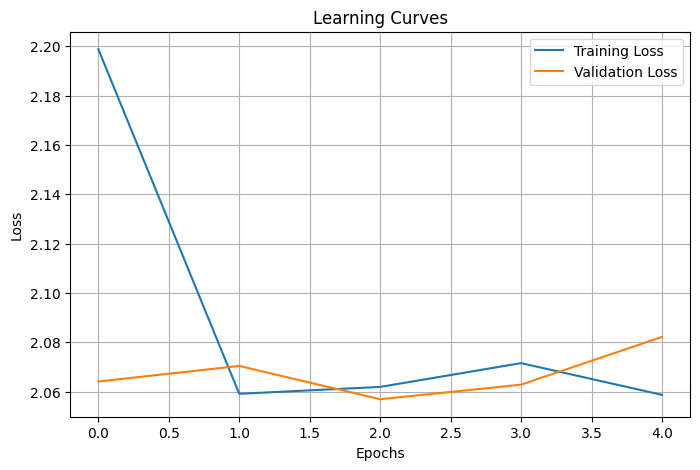

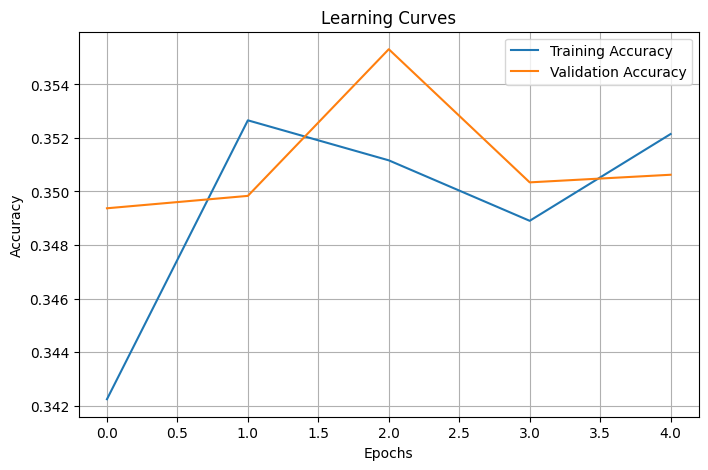

Valid labels after filtering: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


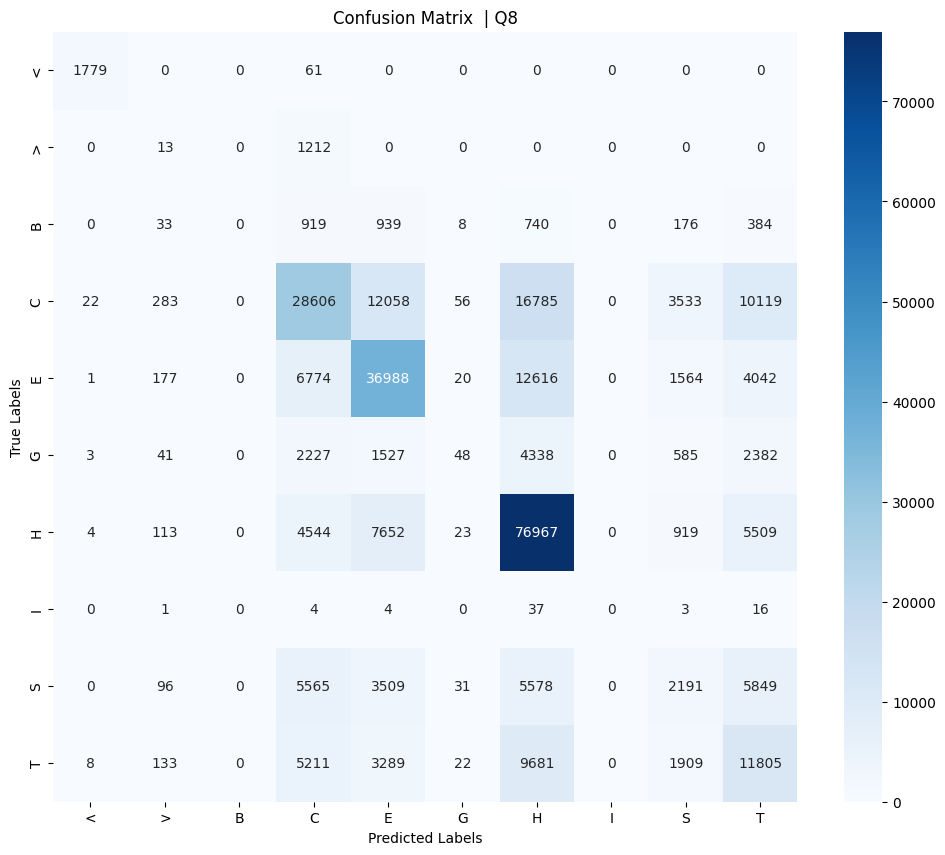

In [ ]:
# Results
plot_learning_curves(tr)
plot_confusion_matrix(ens, tr, q8_itos, q8_stoi, title='Confusion Matrix  | Q8')

# Conclusion: Presents better evolutions than the Q3, nevertheless it is still
# not very promising.

## Hyperparameter Tuning

In [ ]:
# Grid Search Function
def cv_grid(data , space , hy):
    """This function returns the optimal width and depth of the network"""

    hy_space_vals = list(space.values())
    comb = [(i, j, k) for i in hy_space_vals[0] for j in hy_space_vals[1] for k in hy_space_vals[2]]
    print(f'{len(comb)} Hyperparameter Combinations will be evaluated:\n')
    cross_validation_accuracies = {}
    cross_validation_f1s = {}

    for c in comb:
        cross_validation_accuracies[c] = {'Train':[], 'Validation':[]}
        cross_validation_f1s[c] = {'Train':[], 'Validation':[]}

    for c in range(len(comb)):
        print(f'Combination {c+1}/{len(comb)} | Head Size: {comb[c][0]} | FF-Multiplier: {comb[c][1]} | Reduc: {comb[c][2]:.4f}')
        for i in range(hy['kfold']):
            data = {'x_train':X[datasets['train'][i],:] , 'y_train':Y_q3[datasets['train'][i],:] ,
                    'x_val':X[datasets['val'][i],:] , 'y_val':Y_q3[datasets['val'][i],:]}

            ens = EnsembleProtein(vs = hy['vs'] , lstm=lstm_q3 , cnn=cnn_q3 , hs=comb[c][0] , ff=comb[c][1] , dropout=hy['dropout'])
            ens.to(device)

            loss_fn = Diversity_Loss(reduc=comb[c][2] , T=context_size , C=hy['vs'] , stoi=q3_stoi)

            tl = Training(data=data , model=ens , hyperparams=hy , loss_func=loss_fn , verbose=False)
            tl()

            cross_validation_accuracies[comb[c]]['Train'].append(tl.hist_acc['train'])
            cross_validation_accuracies[comb[c]]['Validation'].append(tl.hist_acc['val'])
            cross_validation_f1s[comb[c]]['Train'].append(tl.hist_f1['train'])
            cross_validation_f1s[comb[c]]['Validation'].append(tl.hist_f1['val'])

    for c in comb:
        # Calculating average accuracies & times for each epoch of each combination
        cross_validation_accuracies[c]['Train'] = [sum(records)/hy['kfold']
                                                   for records in zip(*cross_validation_accuracies[c]['Train'])]
        cross_validation_accuracies[c]['Validation'] = [sum(records)/hy['kfold']
                                                   for records in zip(*cross_validation_accuracies[c]['Validation'])]
        cross_validation_f1s[c]['Train'] = [sum(records)/hy['kfold']
                                                   for records in zip(*cross_validation_f1s[c]['Train'])]
        cross_validation_f1s[c]['Validation'] = [sum(records)/hy['kfold']
                                                   for records in zip(*cross_validation_f1s[c]['Validation'])]

    return cross_validation_accuracies, cross_validation_f1s


In [ ]:
# K-Fold CV Splitting

datasets = {'train':[] , 'val':[]}
folds = 3
k = KFold(n_splits=folds, shuffle=True, random_state=42)
for tr,vl in k.split(np.array([i for i in range(X.shape[0])])):
    tr = torch.tensor(tr , dtype=torch.int , device=device)
    vl = torch.tensor(vl , dtype=torch.int , device=device)
    datasets['train'].append(tr)
    datasets['val'].append(vl)

In [ ]:
# Hyperparameter Space
head_sizes = [8, 16 , 32]
ffs  = [4 , 8 , 16]
reducs = list(torch.exp(torch.linspace(-7 , -3 , steps = 5)).cpu().numpy()) # Logarithmic scale
hy_space = {'hs' : head_sizes , 'ff' : ffs , 'reduc' : reducs}

# Not-to-tune Hyperparams
hy = {'batch_size':int(best_params_q3['batch_size']) , 'epochs':5 , 'lr':best_params_q3['lr'] ,
      'eval_int':eval_interval , 'patience':int(best_params_q3['patience']) , 'factor':best_params_q3['factor'] ,
      'min_delta':best_params_q3['min_delta'] , 'vs':q3_vocab_size , 'kfold':folds, 'dropout':dropout}

In [ ]:
cross_validation_accuracies, cross_validation_f1s = cv_grid(data=datasets , space=hy_space , hy=hy)

45 Hyperparameter Combinations will be evaluated:

Combination 1/45 | Head Size: 8 | FF-Multiplier: 4 | Reduc: 0.0009
Combination 2/45 | Head Size: 8 | FF-Multiplier: 4 | Reduc: 0.0025
Combination 3/45 | Head Size: 8 | FF-Multiplier: 4 | Reduc: 0.0067
Combination 4/45 | Head Size: 8 | FF-Multiplier: 4 | Reduc: 0.0183
Combination 5/45 | Head Size: 8 | FF-Multiplier: 4 | Reduc: 0.0498
Combination 6/45 | Head Size: 8 | FF-Multiplier: 8 | Reduc: 0.0009
Combination 7/45 | Head Size: 8 | FF-Multiplier: 8 | Reduc: 0.0025
Combination 8/45 | Head Size: 8 | FF-Multiplier: 8 | Reduc: 0.0067
Combination 9/45 | Head Size: 8 | FF-Multiplier: 8 | Reduc: 0.0183
Combination 10/45 | Head Size: 8 | FF-Multiplier: 8 | Reduc: 0.0498
Combination 11/45 | Head Size: 8 | FF-Multiplier: 16 | Reduc: 0.0009
Combination 12/45 | Head Size: 8 | FF-Multiplier: 16 | Reduc: 0.0025
Combination 13/45 | Head Size: 8 | FF-Multiplier: 16 | Reduc: 0.0067
Combination 14/45 | Head Size: 8 | FF-Multiplier: 16 | Reduc: 0.0183
Co

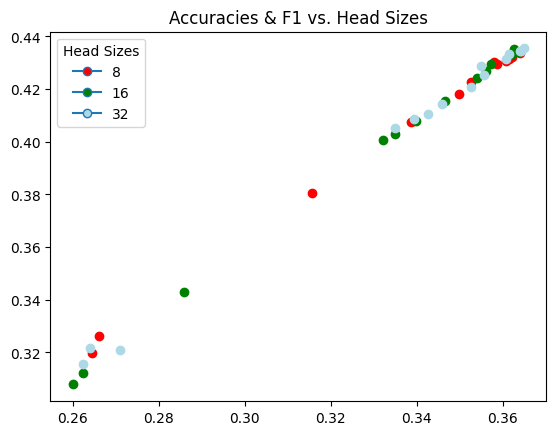

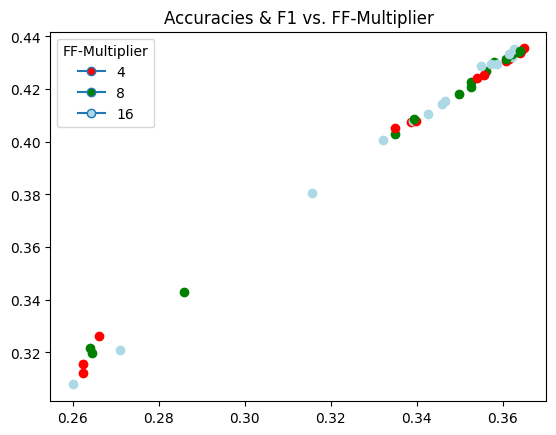

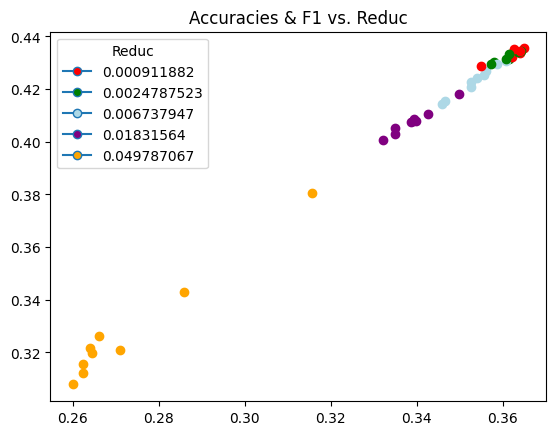

In [ ]:
# Plotting the Results

# Head Sizes
cmap = ['red','green','lightblue']
colors = {i[0]:i[1] for i in zip(head_sizes,cmap)}
plt.figure(1)
for k in cross_validation_accuracies.keys():
  plt.scatter(cross_validation_f1s[k]['Validation'][-1] , cross_validation_accuracies[k]['Validation'][-1] , c=colors[k[0]] , label=k[0])
plt.title('Accuracies & F1 vs. Head Sizes')
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=color, label=label)
           for label, color in colors.items()]
plt.legend(handles=handles, title="Head Sizes")
plt.show()

# FF Multipliers
colors = {i[0]:i[1] for i in zip(ffs,cmap)}
plt.figure(1)
for k in cross_validation_accuracies.keys():
    plt.scatter(cross_validation_f1s[k]['Validation'][-1] , cross_validation_accuracies[k]['Validation'][-1] , c=colors[k[1]])
plt.title('Accuracies & F1 vs. FF-Multiplier')
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=color, label=label)
           for label, color in colors.items()]
plt.legend(handles=handles, title="FF-Multiplier")
plt.show()

# Reducs
cmap = ['red','green','lightblue','purple','orange']
colors = {i[0]:i[1] for i in zip(reducs,cmap)}
plt.figure(1)
for k in cross_validation_accuracies.keys():
    plt.scatter(cross_validation_f1s[k]['Validation'][-1] , cross_validation_accuracies[k]['Validation'][-1] , c=colors[k[2]])
plt.title('Accuracies & F1 vs. Reduc')
handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=color, label=label)
           for label, color in colors.items()]
plt.legend(handles=handles, title="Reduc")
plt.show()


# Conclusion: Both the Head Size and the FF-Multiplier does not appear to have
# a clear effect on the CV-Accuracy score. However, it is evident that the reduc
# hyperparameter has holds an inverse correlation with the accuracy, as the smaller
# it is, the bigger the accuracy. This is problematic, since it might actually mean
# that the penalty term is useless. Still, the experiment will be finilized training
# and testing an ensemble model.

## Model with Optimized Parameters

#### Q3

In [ ]:
# Inputs
loss_func = Diversity_Loss(reduc=2.5e-3 , T=context_size , C=len(q3_stoi) , stoi=q3_stoi)
# Pseudo-Optimal reduc parameter, taken from the CV. However, it was selected the second
# to smallest reduc, since the difference in accuracy between the smallest and second to smallest
# was not very noticeable and it is intended to test the effectiveness of the Diversity Loss

data = {'x_train':X , 'y_train':Y_q3 , 'x_val':X , 'y_val':Y_q3}

hy = {'batch_size':int(best_params_q3['batch_size']) , 'epochs':max_iters , 'lr':best_params_q3['lr'] ,
      'eval_int':eval_interval , 'patience':int(best_params_q3['patience']) , 'factor':best_params_q3['factor'] , 'min_delta':best_params_q3['min_delta']}

ens = EnsembleProtein(vs = q3_vocab_size , lstm=lstm_q3 , cnn=cnn_q3 , hs=16 , ff=8 , dropout=dropout) # Best hyperparameters
ens.to(device)
print(f"Model's trainable parameters: {sum([i.numel() for i in ens.parameters()])}")


# Training Loop
tr = Training(data=data , model=ens , hyperparams=hy , loss_func=loss_func , verbose=True , valid=False)
tr()
# Saving Model
torch.save(ens.state_dict(), 'Q3_protein_ensemble.pth')

Model's trainable parameters: 252489
Epoch: 1/15 | Training Loss: 1.34745 | Training Accuracy: 0.43394 |Training Precision: 0.65863 | Training F1-Score: 0.36289
Epoch: 2/15 | Training Loss: 1.31906 | Training Accuracy: 0.43428 |Training Precision: 0.65933 | Training F1-Score: 0.36342
Epoch: 3/15 | Training Loss: 1.31905 | Training Accuracy: 0.43430 |Training Precision: 0.65941 | Training F1-Score: 0.36346
Epoch: 4/15 | Training Loss: 1.31898 | Training Accuracy: 0.43419 |Training Precision: 0.65936 | Training F1-Score: 0.36338
Epoch: 5/15 | Training Loss: 1.31899 | Training Accuracy: 0.43420 |Training Precision: 0.65938 | Training F1-Score: 0.36340
Epoch: 6/15 | Training Loss: 1.31913 | Training Accuracy: 0.43424 |Training Precision: 0.65947 | Training F1-Score: 0.36347
Epoch: 7/15 | Training Loss: 1.31906 | Training Accuracy: 0.43435 |Training Precision: 0.65944 | Training F1-Score: 0.36352
Epoch: 8/15 | Training Loss: 1.31891 | Training Accuracy: 0.43411 |Training Precision: 0.65946 

In [ ]:
# Testing
# Creating initial model
pr = EnsembleProtein(vs = q3_vocab_size , lstm=lstm_q3 , cnn=cnn_q3 , hs=16 , ff=8 , dropout=dropout)
pr.to(device)
# Loading weights
state_dict = torch.load('/content/Q3_protein_ensemble.pth')
pr.load_state_dict(state_dict)
pr.eval()

print(q3_stoi,'\n\n')
count = 0
acc_total = 0
for i in range(df_test.shape[0]):
  count += 1
  # Predicting & Decoding Structure
  pred = q3_decoder(pr.inference(list(df_test['seq'])[i] , seq_encoder).cpu().numpy().flatten()[0:len(list(df_test['sst3'])[i])])
  pred = [item for i in pred for item in (i if isinstance(i, tuple) else [i])][0:len(list(df_test['sst3'])[i])]
  final_pred = ''.join(pred)
  ground_truth = list(df_test['sst3'])[i]
  acc = [1 if i[0] == i[1] else 0 for i in zip(final_pred[1:],ground_truth)]
  acc_perc = sum(acc)/len(acc)
  acc_total += acc_perc

  # Checking Results
  if i % 10 == 0:
    print(f'Predicted structure:\n' , final_pred)
    print(f'True structure:\n' , ground_truth)
    print(f'Accuracy: {acc_perc} \n\n')
print(f'Average Accuracy: {acc_total/count}')
# Conclusion: the accuracy is techinically the middle point of the LSTM's and the CNN's

<ipython-input-102-1f8089feadbc>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/Q3_protein_ensemble.pth')


{'.': 0, '<': 1, '>': 2, 'C': 3, 'E': 4, 'H': 5} 


Predicted structure:
 CCCCCCCCCCCCCCCHECCCCCEHEEEEEEHHCHHHHHHCHHHHHCCCCCCCEECECCHCHHHEHHHHHHHHH>><CHHCCCCCCHEHECEHEHHHHHHHCCCHHCHECEHCHHCHHHCHCHHHHHHCHHCCCECCCCEEECCCCHCHHHHHHHCHHHHHHHHHCCHCHHHEHHHCHCCCHHHCCHHCHCHEEHHEHHHHCCCHCHECCCCCEHCHCCHEHHEECECHECHEHHCCHHHHHHHEHCHHCCCCECHHEHEHCECCHHCHCHEHHHHCCEEEHHHHCHCHHHCCECEHHHHHECEHECCEECHCHHHC
True structure:
 CCCCCCCCCCCCCCCCCCCCCHHHHCCCCCCCHHHHHHHHHHHHCCCCHHHCCCHHHHHHHHHCCHHHHHHCHHHHHHHHHHHHHHHHHCHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCHHHHCCHHHHHHHCCHHHHHHHHCCCCCCHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCCCCC
Accuracy: 0.5492063492063493 


Predicted structure:
 CCCECCECECCCEEECCCCCCCCCECCEEEEEEHCCECEEEEEEEECHCEEEECEECCCEEHEEEHCECCCCEHCEEEEEEEECECCCCHHEEECCCCCEEEEEECCCEHHEHHCHECCCEEEHEHEECCHCEEHEEEEEEHCEHEEHHCC<CEEEEHCCECCCCCCEEEHCCCCEHCCECCEECECCEHEEEECCCHHHCHHCHHHCHCCCCHEECEEEE

#### Q8

In [ ]:
# Inputs
loss_func = Diversity_Loss(reduc=2.5e-3 , T=context_size , C=len(q8_stoi) , stoi=q8_stoi)
# Pseudo-Optimal reduc parameter, taken from the CV. However, it was selected the second
# to smallest reduc, since the difference in accuracy between the smallest and second to smallest
# was not very noticeable and it is intended to test the effectiveness of the Diversity Loss

data = {'x_train':X , 'y_train':Y_q8 , 'x_val':X , 'y_val':Y_q8}

hy = {'batch_size':int(best_params_q3['batch_size']) , 'epochs':max_iters , 'lr':best_params_q3['lr'] ,
      'eval_int':eval_interval , 'patience':int(best_params_q3['patience']) , 'factor':best_params_q3['factor'] , 'min_delta':best_params_q3['min_delta']}

ens = EnsembleProtein(vs = q8_vocab_size , lstm=lstm_q8 , cnn=cnn_q8 , hs=16 , ff=8 , dropout=dropout)
ens.to(device)
print(f"Model's trainable parameters: {sum([i.numel() for i in ens.parameters()])}")


# Training Loop
tr = Training(data=data , model=ens , hyperparams=hy , loss_func=loss_func , verbose=True , valid=False)
tr()
# Saving Model
torch.save(ens.state_dict(), 'Q8_protein_ensemble.pth')

Model's trainable parameters: 53066
Epoch: 1/15 | Training Loss: 1.74715 | Training Accuracy: 0.35431 |Training Precision: 0.60968 | Training F1-Score: 0.29304
Epoch: 2/15 | Training Loss: 1.73947 | Training Accuracy: 0.35528 |Training Precision: 0.61899 | Training F1-Score: 0.29334
Epoch: 3/15 | Training Loss: 1.73894 | Training Accuracy: 0.35477 |Training Precision: 0.61812 | Training F1-Score: 0.29335
Epoch: 4/15 | Training Loss: 1.73838 | Training Accuracy: 0.35542 |Training Precision: 0.61931 | Training F1-Score: 0.29333
Epoch: 5/15 | Training Loss: 1.73895 | Training Accuracy: 0.35522 |Training Precision: 0.61855 | Training F1-Score: 0.29332
Epoch: 6/15 | Training Loss: 1.73959 | Training Accuracy: 0.35506 |Training Precision: 0.61848 | Training F1-Score: 0.29324
Epoch: 7/15 | Training Loss: 1.73828 | Training Accuracy: 0.35529 |Training Precision: 0.61964 | Training F1-Score: 0.29341
Epoch: 8/15 | Training Loss: 1.73727 | Training Accuracy: 0.35534 |Training Precision: 0.61970 |

In [ ]:
# Testing
# Creating initial model
pr = EnsembleProtein(vs = q8_vocab_size , lstm=lstm_q8 , cnn=cnn_q8 , hs=16 , ff=8 , dropout=dropout)
pr.to(device)
# Loading weights
state_dict = torch.load('/content/Q8_protein_ensemble.pth')
pr.load_state_dict(state_dict)
pr.eval()

print(q8_stoi,'\n\n')
count = 0
acc_total = 0
for i in range(df_test.shape[0]):
  count += 1
  # Predicting & Decoding Structure
  pred = q8_decoder(pr.inference(list(df_test['seq'])[i] , seq_encoder).cpu().numpy().flatten()[0:len(list(df_test['sst3'])[i])])
  pred = [item for i in pred for item in (i if isinstance(i, tuple) else [i])][0:len(list(df_test['sst8'])[i])]
  final_pred = ''.join(pred)
  ground_truth = list(df_test['sst8'])[i]
  acc = [1 if i[0] == i[1] else 0 for i in zip(final_pred[1:],ground_truth)]
  acc_perc = sum(acc)/len(acc)
  acc_total += acc_perc

  # Checking Results
  if i % 10 == 0:
    print(f'Predicted structure:\n' , final_pred)
    print(f'True structure:\n' , ground_truth)
    print(f'Accuracy: {acc_perc} \n\n')
print(f'Average Accuracy: {acc_total/count}')
# Conclusion: the accuracy is techinically the middle point of the LSTM's and the CNN's

<ipython-input-98-d8c41877cf01>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/Q8_protein_ensemble.pth')


{'.': 0, '<': 1, '>': 2, 'B': 3, 'C': 4, 'E': 5, 'G': 6, 'H': 7, 'I': 8, 'S': 9, 'T': 10} 


Predicted structure:
 CCCCCCCCCCCCCCCCECCHETCCEECEEESCTCCBHHEHHHHCHSCCTCCGECCCTHCGTHTHHETCHGCHHHCTGECHEGTGEEEHHHESCCHHHHHHHTCTGHEEEEEBHTTSTTBCEHHHTHCHCHHTCTHEEGHEEHECCTCCEHHEHHHGGHHHHHHTGTCHEHEHHHHHHHTHHHHBHHCSTGHEHHHHHHTHTCBCSGTETEEEECTCHTHEECEEEEEEEHEHGTGCHHHHHHEHHCCHH<ECHHCHHHHHHHTCEHHHHHHHHGHHEHHHEHHHHHHHHHHTCTSGGHHHTHEHHEHCHTHCGTCC
True structure:
 CCCCCCCCCCCCCCCCCCCCCHHHHSCCCTTCHHHHHHHHHHHHCCCCGGGCCCHHHHHHHHHSCHHHHHHTHHHHHHHHHHHHHHHHHTHHHHHHHHHTTCHHHHHHHHHHHHHHHHHHHHHHHHHHHHTCTTSCGGGGCCHHHHHHHTTHHHHHHHHTTTCCCHHHHHHHHHHHHTTTTTTHHHHHHHHHHHHHHHHTCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCTTHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHTTCCCCHHHHHHHHHHHHHHHHHTSCCCCCCCCCCCCCCCCCCC
Accuracy: 0.41904761904761906 


Predicted structure:
 <CCCCCEECECECHCTGHHGGCCCCCCHEESCESCEECTCEEEEECTTEEEEEEETTSEBEEEEHCHHTGTSCCTEECEEEEEEGSTSCCEEEEECCEEEEEEECTHTHEECCCEHTSCCCEEEGHTEETTSSCEEEEECTGHEEEETECSEEEEEEESSEETGEGECEEHTTCSEHCE